In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium

import statsmodels.stats.api as sm
from pysal.lib import weights
from pysal.model import spreg
from sklearn.cluster import DBSCAN

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm

from matplotlib import pyplot as plt
import seaborn as sns
import contextily as cx

2024-05-04 16:41:31.418955: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("properties_with_driving.csv")
df = pd.get_dummies(df, columns=["type"], drop_first=True, dtype=int)
df['mean_attraction'] = df['mean_attraction_food'] + df['mean_attraction_groceries']
df = df.loc[df['listPrice'] != 0]
df['log_price'] = np.log(df['listPrice'])
df

Unnamed: 0         address/street  baths  beds  coordinates/latitude  \
0             0        809 S Aurora St    2.0   5.0             42.430851   
1             1      419 Triphammer Rd    2.0   6.0             42.460409   
2             2        517 S Aurora St    2.0   6.0             42.435014   
3             3            3 Hudson Pl    1.0   2.0             42.430688   
4             4  600 Warren Rd Apt 4-2    1.5   1.5             42.477345   
..          ...                    ...    ...   ...                   ...   
222         222       519 E Buffalo St    1.0   2.0             42.441285   
223         223       106 Wiedmaier Ct    2.0   3.0             42.413681   
224         224        409 College Ave    1.0   1.5             42.442255   
225         225       103 Wiedmaier Ct    1.5   3.0             42.413895   
226         226          902 Dryden Rd    1.5   2.5             42.453703   

     coordinates/longitude  garage          id  listPrice  is_manual  ...  \
0               -76.496069       0  4208852367     2625.0      False  ...   
1               -76.481516       4  4733433667     5000.0      False  ...   
2               -76.494344       0  4090421202     4350.0      False  ...   
3               -76.493156       0  4199200488     1600.0      False  ...   
4               -76.467567       0  9934501911     1881.0       True  ...   
..                     ...     ...         ...        ...        ...  ...   
222             -76.490701       0  3834217847     1200.0      False  ...   
223             -76.449093       0  3610937531     3244.0       True  ...   
224             -76.484963       0  9523596613     4095.0       True  ...   
225             -76.448010       0  3609558692     1450.0       True  ...   
226             -76.444380       0  3409039337     1975.0       True  ...   

    local/flood/flood_factor_score  local/noise/score  \
0                              1.0               84.0   
1                              1.0               93.0   
2                              1.0               81.0   
3                              1.0               84.0   
4                              1.0               75.0   
..                             ...                ...   
222                            1.0               79.0   
223                            1.0               80.0   
224                            1.0               73.0   
225                            1.0               77.0   
226                            3.0               74.0   

    local/wildfire/fire_factor_score  amenity_count  driving_time  \
0                                3.0              4           485   
1                                2.0              7           228   
2                                3.0              0           457   
3                                1.0              3           535   
4                                2.0              6           536   
..                               ...            ...           ...   
222                              2.0              3           244   
223                              1.0              2           565   
224                              3.0              0           185   
225                              2.0              3           548   
226                              2.0              2           331   

     type_condos  type_other  type_single_family  mean_attraction  log_price  
0              0           0                   1        91.107927   7.872836  
1              0           0                   1        48.810843   8.517193  
2              0           0                   1       113.112672   8.377931  
3              0           0                   1        78.461897   7.377759  
4              0           0                   0        25.755512   7.539559  
..           ...         ...                 ...              ...        ...  
222            0           1                   0       120.120507   7.090077  
223      

In [3]:
df['log_transit_time_cornell'] = np.log(df['transit_time_cornell'])
df['z_mean_attraction_food'] = (df['mean_attraction_food'] - df['mean_attraction_food'].mean()) / df['mean_attraction_food'].std()
df['z_mean_attraction_groceries'] = (df['mean_attraction_groceries'] - df['mean_attraction_groceries'].mean()) / df['mean_attraction_groceries'].std()

In [4]:
df = df.dropna(subset=['coordinates/latitude', 'coordinates/longitude'])

In [5]:
gdf = gpd.GeoDataFrame(data = df, geometry = gpd.points_from_xy(df['coordinates/longitude'], df['coordinates/latitude'], crs="EPSG:4326"))
gdf.explore('log_price')

In [6]:
gdf_proj = gdf.to_crs("EPSG:3857")
gdf_proj['x'] = gdf_proj.geometry.x
gdf_proj['y'] = gdf_proj.geometry.y
gdf_proj

Unnamed: 0         address/street  baths  beds  coordinates/latitude  \
0             0        809 S Aurora St    2.0   5.0             42.430851   
1             1      419 Triphammer Rd    2.0   6.0             42.460409   
2             2        517 S Aurora St    2.0   6.0             42.435014   
3             3            3 Hudson Pl    1.0   2.0             42.430688   
4             4  600 Warren Rd Apt 4-2    1.5   1.5             42.477345   
..          ...                    ...    ...   ...                   ...   
222         222       519 E Buffalo St    1.0   2.0             42.441285   
223         223       106 Wiedmaier Ct    2.0   3.0             42.413681   
224         224        409 College Ave    1.0   1.5             42.442255   
225         225       103 Wiedmaier Ct    1.5   3.0             42.413895   
226         226          902 Dryden Rd    1.5   2.5             42.453703   

     coordinates/longitude  garage          id  listPrice  is_manual  ...  \
0               -76.496069       0  4208852367     2625.0      False  ...   
1               -76.481516       4  4733433667     5000.0      False  ...   
2               -76.494344       0  4090421202     4350.0      False  ...   
3               -76.493156       0  4199200488     1600.0      False  ...   
4               -76.467567       0  9934501911     1881.0       True  ...   
..                     ...     ...         ...        ...        ...  ...   
222             -76.490701       0  3834217847     1200.0      False  ...   
223             -76.449093       0  3610937531     3244.0       True  ...   
224             -76.484963       0  9523596613     4095.0       True  ...   
225             -76.448010       0  3609558692     1450.0       True  ...   
226             -76.444380       0  3409039337     1975.0       True  ...   

    type_other  type_single_family mean_attraction  log_price  \
0            0                   1       91.107927   7.872836   
1            0                   1       48.810843   8.517193   
2            0                   1      113.112672   8.377931   
3            0                   1       78.461897   7.377759   
4            0                   0       25.755512   7.539559   
..         ...                 ...             ...        ...   
222          1                   0      120.120507   7.090077   
223          0                   0       30.848252   8.084562   
224          0                   0      218.955272   8.317522   
225          0                   0       31.319102   7.279319   
226          0                   0       32.786191   7.588324   

     log_transit_time_cornell  z_mean_attraction_food  \
0                    3.495424               -0.216326   
1                    2.929948               -0.444968   
2                    3.301495               -0.084789   
3                    3.462076               -0.290713   
4                    3.962625               -0.551249   
..                        ...                     ...   
222                  2.800157                0.000628   
223                  4.196756               -0.549702   
224                  2.205284                0.760800   
225                  4.179232               -0.547577   
226                  3.757848               -0.536137   

     z_mean_attraction_groceries                          geometry  \
0                       0.170020  POINT (-8515503.449 5225738.932)   
1                      -0.990721  POINT (-8513883.416 5230197.938)   
2                       0.649643  POINT (-8515311.423 5226366.819)   
3                      -0.117531  POINT (-8515179.175 5225714.348)   
4                      -1.804516  POINT (-8512330.621 5232753.787)   
..                           ...                               ...   
222                     0.372770  POINT (-8514905.886 5227312.725)   
223                    -1.408310  POINT (-8510274.104 5223149.697)   
224                     0.855244  POINT (-8514267.135 52274

In [7]:
gdf_proj.columns

Index(['Unnamed: 0', 'address/street', 'baths', 'beds', 'coordinates/latitude',
       'coordinates/longitude', 'garage', 'id', 'listPrice', 'is_manual',
       'name', 'sqft', 'status', 'stories', 'units', 'year_built',
       'transit_time_cornell', 'transit_time_schools',
       'mean_transit_time_food', 'mean_attraction_food',
       'mean_transit_time_groceries', 'mean_attraction_groceries',
       'local/flood/flood_factor_score', 'local/noise/score',
       'local/wildfire/fire_factor_score', 'amenity_count', 'driving_time',
       'type_condos', 'type_other', 'type_single_family', 'mean_attraction',
       'log_price', 'log_transit_time_cornell', 'z_mean_attraction_food',
       'z_mean_attraction_groceries', 'geometry', 'x', 'y'],
      dtype='object')

In [8]:
df.columns

Index(['Unnamed: 0', 'address/street', 'baths', 'beds', 'coordinates/latitude',
       'coordinates/longitude', 'garage', 'id', 'listPrice', 'is_manual',
       'name', 'sqft', 'status', 'stories', 'units', 'year_built',
       'transit_time_cornell', 'transit_time_schools',
       'mean_transit_time_food', 'mean_attraction_food',
       'mean_transit_time_groceries', 'mean_attraction_groceries',
       'local/flood/flood_factor_score', 'local/noise/score',
       'local/wildfire/fire_factor_score', 'amenity_count', 'driving_time',
       'type_condos', 'type_other', 'type_single_family', 'mean_attraction',
       'log_price', 'log_transit_time_cornell', 'z_mean_attraction_food',
       'z_mean_attraction_groceries'],
      dtype='object')

In [9]:
variable_names = ['baths', 'beds', 
                  #'garage', 
                  'sqft', 
                  #'units', 
                  'transit_time_cornell', 'z_mean_attraction_food', 'z_mean_attraction_groceries',
                  'type_condos', 'type_other', 'type_single_family', 
                  'local/flood/flood_factor_score', 'local/noise/score','local/wildfire/fire_factor_score', 'amenity_count']

In [10]:
gdf = gdf.dropna(subset=variable_names)

In [11]:
gdf

Unnamed: 0         address/street  baths  beds  coordinates/latitude  \
0             0        809 S Aurora St    2.0   5.0             42.430851   
1             1      419 Triphammer Rd    2.0   6.0             42.460409   
2             2        517 S Aurora St    2.0   6.0             42.435014   
3             3            3 Hudson Pl    1.0   2.0             42.430688   
4             4  600 Warren Rd Apt 4-2    1.5   1.5             42.477345   
..          ...                    ...    ...   ...                   ...   
222         222       519 E Buffalo St    1.0   2.0             42.441285   
223         223       106 Wiedmaier Ct    2.0   3.0             42.413681   
224         224        409 College Ave    1.0   1.5             42.442255   
225         225       103 Wiedmaier Ct    1.5   3.0             42.413895   
226         226          902 Dryden Rd    1.5   2.5             42.453703   

     coordinates/longitude  garage          id  listPrice  is_manual  ...  \
0               -76.496069       0  4208852367     2625.0      False  ...   
1               -76.481516       4  4733433667     5000.0      False  ...   
2               -76.494344       0  4090421202     4350.0      False  ...   
3               -76.493156       0  4199200488     1600.0      False  ...   
4               -76.467567       0  9934501911     1881.0       True  ...   
..                     ...     ...         ...        ...        ...  ...   
222             -76.490701       0  3834217847     1200.0      False  ...   
223             -76.449093       0  3610937531     3244.0       True  ...   
224             -76.484963       0  9523596613     4095.0       True  ...   
225             -76.448010       0  3609558692     1450.0       True  ...   
226             -76.444380       0  3409039337     1975.0       True  ...   

    driving_time  type_condos type_other  type_single_family  mean_attraction  \
0            485            0          0                   1        91.107927   
1            228            0          0                   1        48.810843   
2            457            0          0                   1       113.112672   
3            535            0          0                   1        78.461897   
4            536            0          0                   0        25.755512   
..           ...          ...        ...                 ...              ...   
222          244            0          1                   0       120.120507   
223          565            0          0                   0        30.848252   
224          185            0          0                   0       218.955272   
225          548            0          0                   0        31.319102   
226          331            0          0                   0        32.786191   

     log_price  log_transit_time_cornell  z_mean_attraction_food  \
0     7.872836                  3.495424               -0.216326   
1     8.517193                  2.929948               -0.444968   
2     8.377931                  3.301495               -0.084789   
3     7.377759                  3.462076               -0.290713   
4     7.539559                  3.962625               -0.551249   
..         ...                       ...                     ...   
222   7.090077                  2.800157                0.000628   
223   8.084562                  4.196756               -0.549702   
224   8.317522                  2.205284                0.760800   
225   7.279319                  4.179232               -0.547577   
226   7.588324                  3.757848               -0.536137   

     z_mean_attraction_groceries                    geometry  
0                       0.170020  POINT (-76.49607 42.43085)  
1                      -0.990721  POINT (-76.48152 42.46041)  
2                       0.649643  POINT (-76.49434 42.43501)  
3                      -0.117531  POINT (-76.49316 42.43069)  
4                      -1.804516  POINT (-76.46757

In [12]:
w_kernel = weights.distance.Kernel.from_dataframe(gdf, k=5, diagonal=False)
w_kernel.transform = 'r'
for i in w_kernel.neighbors:
    w_kernel.neighbors[i] = [j for j in w_kernel.neighbors[i] if i != j]
    w_kernel.weights[i] = [w for j, w in zip(w_kernel.neighbors[i], w_kernel.weights[i]) if i != j]


#w_knn = weights.KNN.from_dataframe(gdf, k=5)

In [13]:
lag_model = spreg.GM_Lag(gdf[["listPrice"]].values, gdf[variable_names].values,
                         w=w_kernel,
                         name_y="rent",name_x=variable_names,
)

In [14]:
gdf_proj

Unnamed: 0         address/street  baths  beds  coordinates/latitude  \
0             0        809 S Aurora St    2.0   5.0             42.430851   
1             1      419 Triphammer Rd    2.0   6.0             42.460409   
2             2        517 S Aurora St    2.0   6.0             42.435014   
3             3            3 Hudson Pl    1.0   2.0             42.430688   
4             4  600 Warren Rd Apt 4-2    1.5   1.5             42.477345   
..          ...                    ...    ...   ...                   ...   
222         222       519 E Buffalo St    1.0   2.0             42.441285   
223         223       106 Wiedmaier Ct    2.0   3.0             42.413681   
224         224        409 College Ave    1.0   1.5             42.442255   
225         225       103 Wiedmaier Ct    1.5   3.0             42.413895   
226         226          902 Dryden Rd    1.5   2.5             42.453703   

     coordinates/longitude  garage          id  listPrice  is_manual  ...  \
0               -76.496069       0  4208852367     2625.0      False  ...   
1               -76.481516       4  4733433667     5000.0      False  ...   
2               -76.494344       0  4090421202     4350.0      False  ...   
3               -76.493156       0  4199200488     1600.0      False  ...   
4               -76.467567       0  9934501911     1881.0       True  ...   
..                     ...     ...         ...        ...        ...  ...   
222             -76.490701       0  3834217847     1200.0      False  ...   
223             -76.449093       0  3610937531     3244.0       True  ...   
224             -76.484963       0  9523596613     4095.0       True  ...   
225             -76.448010       0  3609558692     1450.0       True  ...   
226             -76.444380       0  3409039337     1975.0       True  ...   

    type_other  type_single_family mean_attraction  log_price  \
0            0                   1       91.107927   7.872836   
1            0                   1       48.810843   8.517193   
2            0                   1      113.112672   8.377931   
3            0                   1       78.461897   7.377759   
4            0                   0       25.755512   7.539559   
..         ...                 ...             ...        ...   
222          1                   0      120.120507   7.090077   
223          0                   0       30.848252   8.084562   
224          0                   0      218.955272   8.317522   
225          0                   0       31.319102   7.279319   
226          0                   0       32.786191   7.588324   

     log_transit_time_cornell  z_mean_attraction_food  \
0                    3.495424               -0.216326   
1                    2.929948               -0.444968   
2                    3.301495               -0.084789   
3                    3.462076               -0.290713   
4                    3.962625               -0.551249   
..                        ...                     ...   
222                  2.800157                0.000628   
223                  4.196756               -0.549702   
224                  2.205284                0.760800   
225                  4.179232               -0.547577   
226                  3.757848               -0.536137   

     z_mean_attraction_groceries                          geometry  \
0                       0.170020  POINT (-8515503.449 5225738.932)   
1                      -0.990721  POINT (-8513883.416 5230197.938)   
2                       0.649643  POINT (-8515311.423 5226366.819)   
3                      -0.117531  POINT (-8515179.175 5225714.348)   
4                      -1.804516  POINT (-8512330.621 5232753.787)   
..                           ...                               ...   
222                     0.372770  POINT (-8514905.886 5227312.725)   
223                    -1.408310  POINT (-8510274.104 5223149.697)   
224                     0.855244  POINT (-8514267.135 52274

In [15]:
print(lag_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :        rent                Number of Observations:         196
Mean dependent var  :   2280.3699                Number of Variables   :          15
S.D. dependent var  :   1342.0552                Degrees of Freedom    :         181
Pseudo R-squared    :      0.4537
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      6693.17285      3213.60678         2.08276         0.03727
               baths       299.91019       151.71930         1.97674         0.04807
 

One common intuitive pattern to see with housing rents is that more expensive properties tend to be located near other expensive properties. In fact, this type of pattern is a very fundamental concept in spatial data: spatial autocorrelation. This means that the prices are "correlated with themselves" over space. That is, higher values tend to be near other higher values. We employed another technique, called spatial regression, to incorporate this additional information into our prediction model. Specifically, we incorporated the average housing prices of the 5 nearest housing points to be an input variable that predicts the rent of a particular property. This type of model is called a spatial lag model. 

In [16]:
# Define DBSCAN
clusterer = DBSCAN(eps=200, 
                   #min_samples=int(minp)
                  )
# Fit to our data
clusterer.fit(gdf_proj[['x', 'y']])

DBSCAN(eps=200)

In [17]:
lbls = pd.Series(clusterer.labels_, index=gdf_proj.index)

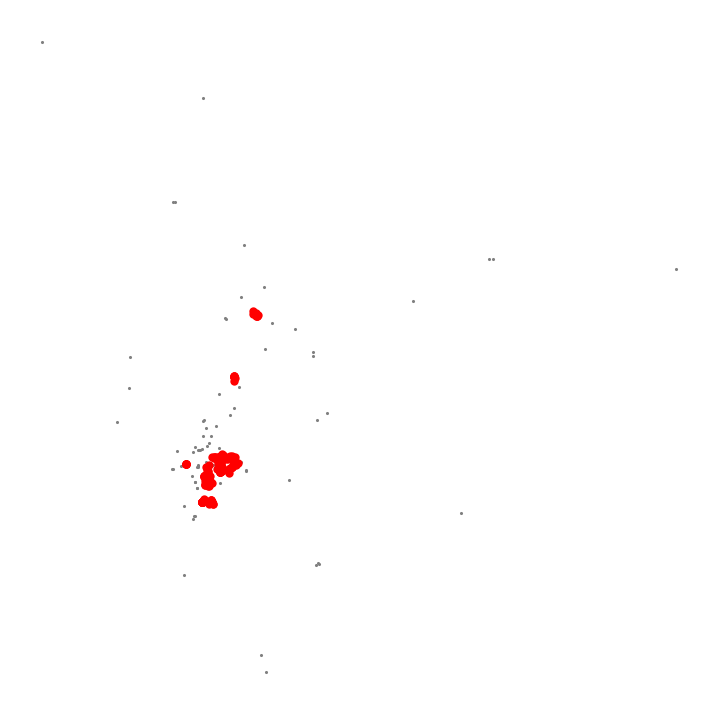

In [18]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Subset points that are not part of any cluster (noise)
noise = gdf_proj.loc[lbls == -1, ['x','y']]
# Plot noise in grey
ax.scatter(noise['x'], noise['y'], c="grey", s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    gdf_proj.loc[gdf_proj.index.difference(noise.index), 'x'],
    gdf_proj.loc[gdf_proj.index.difference(noise.index), 'y'],
    c="red",
    linewidth=0,
)

# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

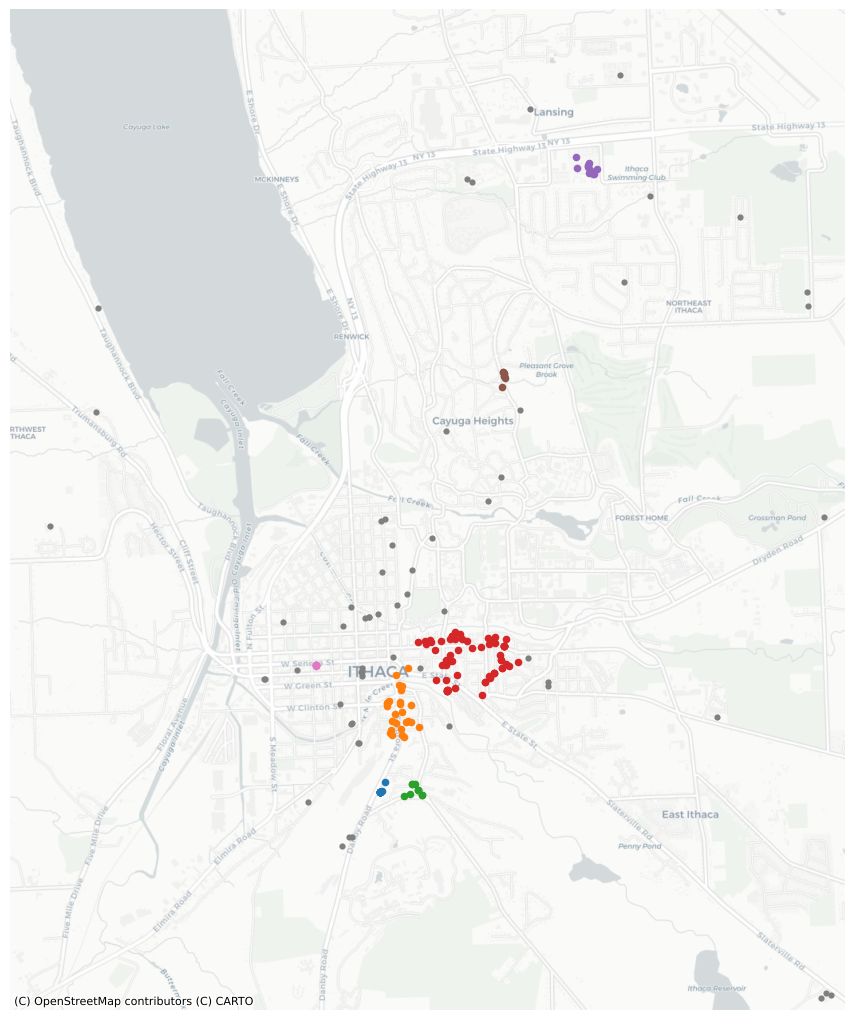

In [19]:
import matplotlib.pyplot as plt
import contextily as ctx

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(13, 13))

# Subset points that are not part of any cluster (noise)
noise = gdf_proj.loc[lbls == -1, ['x', 'y']]
# Plot noise in grey
ax.scatter(noise['x'], noise['y'], c="grey", s=20, linewidth=0)

# Plot clusters with different colors
for label in set(lbls) - {-1}:
    cluster_points = gdf_proj.loc[lbls == label, ['x', 'y']]
    ax.scatter(cluster_points['x'], cluster_points['y'], s=30, linewidth=0)

# Set the zoom level with specified x and y limits
ax.set_xlim(-8.520 * 10**6, -8.510 * 10**6)
ax.set_ylim(5.223 * 10**6, 5.235 * 10**6)

# Manually adjust the zoom level of the basemap
# Add basemap
zoom_level = 14  # You might need to adjust this value based on trial and error
ctx.add_basemap(ax, crs=gdf_proj.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=zoom_level)

# Remove axes
ax.set_axis_off()

# Display the figure
plt.show()


In [20]:
import folium

# Assuming 'x' and 'y' in your gdf_proj are longitude and latitude respectively
# Create a map centered around an average location in your data
m = folium.Map(location=[gdf['coordinates/latitude'].mean(), gdf['coordinates/longitude'].mean()], zoom_start=13)

noise = gdf.loc[lbls == -1, ['coordinates/longitude','coordinates/latitude']]
# Add points for noise
for idx, row in noise.iterrows():
    folium.CircleMarker(location=(row['coordinates/latitude'], row['coordinates/longitude']),
                        radius=3,
                        color='grey',
                        fill=True,
                        fill_color='grey').add_to(m)

# Add points for non-noise data
non_noise_data = gdf.loc[gdf.index.difference(noise.index)]
for idx, row in non_noise_data.iterrows():
    folium.CircleMarker(location=(row['coordinates/latitude'], row['coordinates/longitude']),
                        radius=3,
                        color='red',
                        fill=True,
                        fill_color='red').add_to(m)

# Display the map
m.save('map.html')  # This saves the map as an HTML file you can open in your browser
m

Another interesting question to answer is where are the main areas for renting apartments are in Ithaca. A type of machine learning technique, called Clustering, is especially designed for this type of application. Specifically, we used an algorithm called Density-based spatial clustering of applications with noise (DBSCAN) to do this. We can clearly see that the algorithm identified 4 main areas: Collegetown, Lansing, North of Ithaca College, and Downtown.

In [21]:
acs = pd.read_csv("datasets/R13666053_SL150.csv")
acs['Geo_FIPS'] = acs['Geo_FIPS'].astype(str)
acs.head()

Geo_FIPS                                          Geo_QName Geo_STUSAB  \
0  361090001001  Block Group 1, Census Tract 1, Tompkins County...         ny   
1  361090001002  Block Group 2, Census Tract 1, Tompkins County...         ny   
2  361090002011  Block Group 1, Census Tract 2.01, Tompkins Cou...         ny   
3  361090002012  Block Group 2, Census Tract 2.01, Tompkins Cou...         ny   
4  361090002021  Block Group 1, Census Tract 2.02, Tompkins Cou...         ny   

   Geo_SUMLEV  Geo_GEOCOMP  Geo_US  Geo_REGION  Geo_DIVISION  Geo_STATE  \
0         150            0     NaN         NaN           NaN         36   
1         150            0     NaN         NaN           NaN         36   
2         150            0     NaN         NaN           NaN         36   
3         150            0     NaN         NaN           NaN         36   
4         150            0     NaN         NaN           NaN         36   

   Geo_COUNTY  ...  SE_A10042B_005  SE_A10042B_006  SE_A10042B_007  \
0         109  ...              50               0              32   
1         109  ...              20               0              15   
2         109  ...              64             187              61   
3         109  ...              12              33               0   
4         109  ...              63              27              54   

   SE_A10054B_001  SE_A10054B_002  SE_A10054B_003  SE_A10054B_004  \
0             926             381             461              39   
1             499             186             297              16   
2             930             424             405              37   
3             320             169             151               0   
4             342              75              96              54   

   SE_A10054B_005  SE_A10054B_006  SE_A10054B_007  
0              21              24               0  
1               0               0               0  
2               0              43              21  
3               0               0               0  
4              63              54               0  

[5 rows x 113 columns]

In [22]:
ny_bg = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2022/BG/tl_2022_36_bg.zip")
tk_bg = ny_bg.loc[ny_bg['COUNTYFP'] == "109"]
#tk_bg = tk_bg.loc[tk_bg['ALAND']>0]
tk_bg.head()

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
3069      36      109  000400        1  361090004001  Block Group 1  G5030   
4077      36      109  000800        1  361090008001  Block Group 1  G5030   
4080      36      109  001200        1  361090012001  Block Group 1  G5030   
4081      36      109  000500        2  361090005002  Block Group 2  G5030   
4372      36      109  001000        1  361090010001  Block Group 1  G5030   

     FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
3069        S  4007703   98151  +42.4572467  -076.4584840   
4077        S   899473   94969  +42.4466992  -076.5074522   
4080        S  1337369    6077  +42.4217242  -076.4921665   
4081        S   792164       0  +42.4788272  -076.4756669   
4372        S  2641508   92195  +42.4279008  -076.5163696   

                                               geometry  
3069  POLYGON ((-76.48979 42.45245, -76.48979 42.452...  
4077  POLYGON ((-76.51565 42.43944, -76.51529 42.439...  
4080  POLYGON ((-76.50224 42.41833, -76.50139 42.420...  
4081  POLYGON ((-76.48383 42.48118, -76.48049 42.481...  
4372  POLYGON ((-76.52619 42.42255, -76.52619 42.422...

In [23]:
tk_bg.explore()

In [24]:
tk_bg_data = tk_bg.merge(acs, left_on='GEOID', right_on='Geo_FIPS', 
                         how='outer'
                        )

In [25]:
tk_bg_data.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       ...
       'SE_A10042B_005', 'SE_A10042B_006', 'SE_A10042B_007', 'SE_A10054B_001',
       'SE_A10054B_002', 'SE_A10054B_003', 'SE_A10054B_004', 'SE_A10054B_005',
       'SE_A10054B_006', 'SE_A10054B_007'],
      dtype='object', length=126)

In [26]:
tk_bg_data.rename({'SE_A10001_001':'bg_total_units',
                   'SE_A10047_001':'bg_vacant_units', 'SE_A10047_002':'bg_vacant_units_rent', 
                   'SE_A10060_001':'bg_occupied_units', 'SE_A10060_003': 'bg_occupied_units_rent',
                   'SE_A10057_001':'median_year_structure_built', 
                   'SE_A14024_001':'per_capita_income', 
                   'SE_A00002_001':'bg_total_population', 'SE_A00002_002':'bg_population_density',
                   'SE_A10003B_001':'bg_avg_household_size', 'SE_A17005_003':'bg_unemployed'
                  }, inplace=True, axis=1)
tk_bg_data = tk_bg_data[['GEOID', 'NAMELSAD', 'geometry', 'ALAND', 
                         'bg_total_units',
                         'bg_vacant_units', 'bg_vacant_units_rent', 
                         'bg_occupied_units', 'bg_occupied_units_rent',
                         'median_year_structure_built', 
                         'per_capita_income', 
                         'bg_total_population', 'bg_population_density',
                         'bg_avg_household_size', 'bg_unemployed']].copy()
tk_bg_data.head()

GEOID       NAMELSAD  \
0  361090001001  Block Group 1   
1  361090001002  Block Group 2   
2  361090002011  Block Group 1   
3  361090002012  Block Group 2   
4  361090002021  Block Group 1   

                                            geometry   ALAND  bg_total_units  \
0  POLYGON ((-76.49911 42.44131, -76.49690 42.441...  242032            1056   
1  POLYGON ((-76.50839 42.44011, -76.50618 42.440...  268365             571   
2  POLYGON ((-76.48865 42.44160, -76.48747 42.441...   61084            1039   
3  POLYGON ((-76.48986 42.44242, -76.48986 42.442...   93640             354   
4  POLYGON ((-76.49218 42.44060, -76.49170 42.440...  175296             602   

   bg_vacant_units  bg_vacant_units_rent  bg_occupied_units  \
0              104                     0                952   
1               62                     0                509   
2              109                     0                930   
3               34                     0                320   
4              148                    41                454   

   bg_occupied_units_rent  median_year_structure_built  per_capita_income  \
0                     926                         1993              54824   
1                     499                         1961              30439   
2                     930                         1995              17483   
3                     320                         1991               6150   
4                     342                         1938              16669   

   bg_total_population  bg_population_density  bg_avg_household_size  \
0                 1221              13065.940                   1.24   
1                  663               6398.606                   1.28   
2                 1684              71402.330                   1.81   
3                 1326              36675.820                   2.46   
4                 1281              18926.700                   2.83   

   bg_unemployed  
0             39  
1             20  
2              0  
3              0  
4              0

In [27]:
tk_bg_data['bg_perc_vacant'] = tk_bg_data['bg_vacant_units'] / tk_bg_data['bg_total_units']
tk_bg_data['bg_perc_rent'] = tk_bg_data['bg_occupied_units_rent'] / tk_bg_data['bg_occupied_units']
tk_bg_data['bg_perc_unemployed'] = tk_bg_data['bg_unemployed'] / tk_bg_data['bg_total_population']

In [28]:
tk_bg_data.explore('bg_perc_rent', legend=True)

In [29]:
df_with_acs = gdf.sjoin(tk_bg_data, how='left')
df_with_acs.head()

/Users/stevenzhou/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:2189: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


Unnamed: 0         address/street  baths  beds  coordinates/latitude  \
0           0        809 S Aurora St    2.0   5.0             42.430851   
1           1      419 Triphammer Rd    2.0   6.0             42.460409   
2           2        517 S Aurora St    2.0   6.0             42.435014   
3           3            3 Hudson Pl    1.0   2.0             42.430688   
4           4  600 Warren Rd Apt 4-2    1.5   1.5             42.477345   

   coordinates/longitude  garage          id  listPrice  is_manual  ...  \
0             -76.496069       0  4208852367     2625.0      False  ...   
1             -76.481516       4  4733433667     5000.0      False  ...   
2             -76.494344       0  4090421202     4350.0      False  ...   
3             -76.493156       0  4199200488     1600.0      False  ...   
4             -76.467567       0  9934501911     1881.0       True  ...   

  bg_occupied_units_rent  median_year_structure_built per_capita_income  \
0                   1080                         1971             28690   
1                    435                         1969             50877   
2                   1080                         1971             28690   
3                   1080                         1971             28690   
4                    435                         1969             50877   

   bg_total_population  bg_population_density  bg_avg_household_size  \
0                 2814               951.2947                   1.80   
1                 1856              2033.8310                   1.41   
2                 2814               951.2947                   1.80   
3                 2814               951.2947                   1.80   
4                 1856              2033.8310                   1.41   

   bg_unemployed  bg_perc_vacant  bg_perc_rent  bg_perc_unemployed  
0            202        0.047619      0.739726            0.071784  
1             40        0.031690      0.527273            0.021552  
2            202        0.047619      0.739726            0.071784  
3            202        0.047619      0.739726            0.071784  
4             40        0.031690      0.527273            0.021552  

[5 rows x 54 columns]

In [30]:
df_with_acs.columns

Index(['Unnamed: 0', 'address/street', 'baths', 'beds', 'coordinates/latitude',
       'coordinates/longitude', 'garage', 'id', 'listPrice', 'is_manual',
       'name', 'sqft', 'status', 'stories', 'units', 'year_built',
       'transit_time_cornell', 'transit_time_schools',
       'mean_transit_time_food', 'mean_attraction_food',
       'mean_transit_time_groceries', 'mean_attraction_groceries',
       'local/flood/flood_factor_score', 'local/noise/score',
       'local/wildfire/fire_factor_score', 'amenity_count', 'driving_time',
       'type_condos', 'type_other', 'type_single_family', 'mean_attraction',
       'log_price', 'log_transit_time_cornell', 'z_mean_attraction_food',
       'z_mean_attraction_groceries', 'geometry', 'index_right', 'GEOID',
       'NAMELSAD', 'ALAND', 'bg_total_units', 'bg_vacant_units',
       'bg_vacant_units_rent', 'bg_occupied_units', 'bg_occupied_units_rent',
       'median_year_structure_built', 'per_capita_income',
       'bg_total_population', 'bg_p

In [31]:
df_with_acs['mean_attraction'] = df_with_acs['z_mean_attraction_food'] + df_with_acs['z_mean_attraction_groceries']

In [32]:
variable_names = ['baths',
                  'beds', 
                  'garage', 
                  'sqft', 
                  'units', 
                  'transit_time_cornell', 'driving_time',
                  'z_mean_attraction_food', 'z_mean_attraction_groceries',
                  'type_condos', 'type_other', 'type_single_family', 
                  'local/flood/flood_factor_score', 'local/noise/score',
                  'local/wildfire/fire_factor_score', 'amenity_count'
                 ]

In [33]:
variable_names_acs = variable_names + ['median_year_structure_built', 
                                       'per_capita_income', 
                                       'bg_perc_unemployed', 
                                       'bg_perc_vacant',
                                       'bg_perc_rent', 
                                       'bg_population_density', 
                                       'bg_avg_household_size']

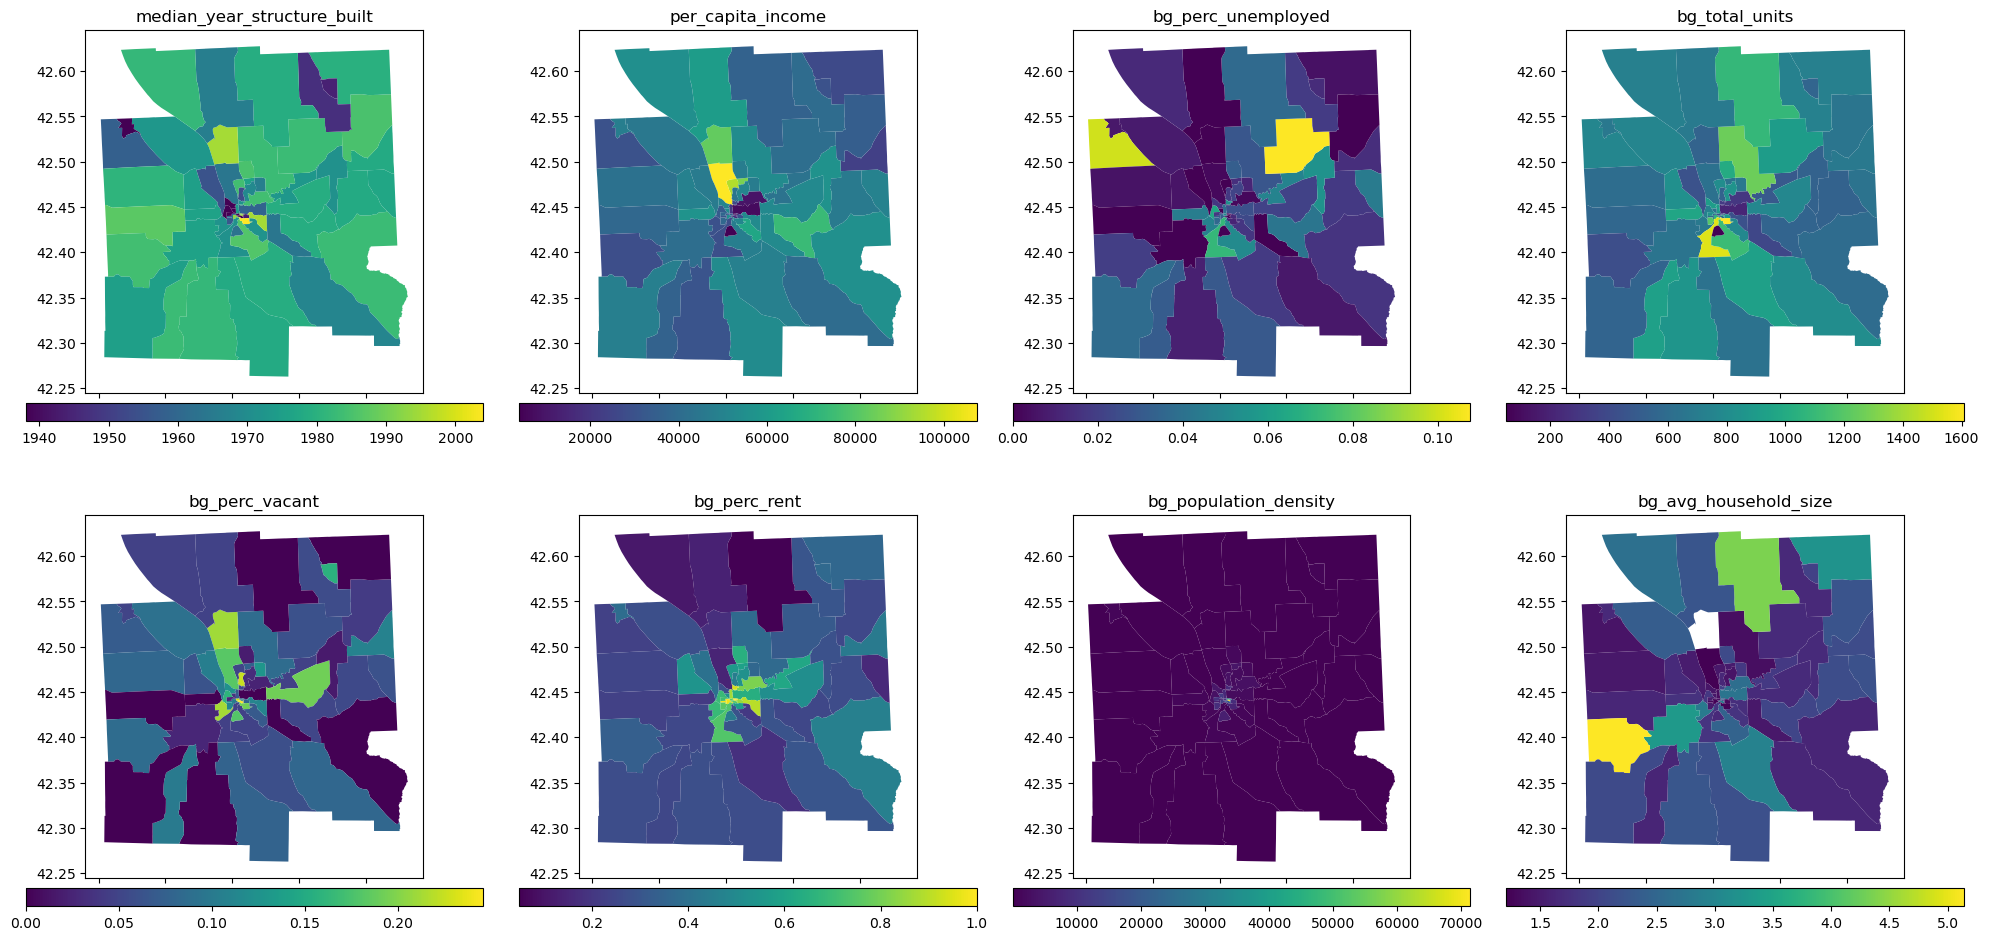

In [34]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Variables to plot
variables = ['median_year_structure_built', 'per_capita_income', 'bg_perc_unemployed', 'bg_total_units',
             'bg_perc_vacant', 'bg_perc_rent', 'bg_population_density', 'bg_avg_household_size']

# Creating subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))  # Adjusted size for better fit
axs = axs.flatten()

for i, var in enumerate(variables):
    ax = axs[i]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    plot = tk_bg_data.plot(column=var, ax=ax, legend=True, cax=cax)
    ax.set_title(var)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Handling colorbar on its own
    plt.colorbar(plot.get_children()[0], cax=cax, orientation='horizontal')

# Hide unused subplots
for ax in axs[len(variables):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


In [35]:
corr = df_with_acs[variable_names_acs+["listPrice"]].corr()
corr

baths      beds    garage      sqft  \
baths                             1.000000  0.678896  0.056425  0.322299   
beds                              0.678896  1.000000  0.136993  0.371989   
garage                            0.056425  0.136993  1.000000  0.239631   
sqft                              0.322299  0.371989  0.239631  1.000000   
units                            -0.039722 -0.131884 -0.019636  0.045622   
transit_time_cornell              0.093949 -0.124782 -0.036153  0.229007   
driving_time                      0.062308 -0.065574 -0.077045  0.249171   
z_mean_attraction_food            0.071796  0.146523 -0.039899 -0.166123   
z_mean_attraction_groceries      -0.080324  0.115862 -0.067382 -0.228978   
type_condos                       0.007342  0.015904 -0.022069  0.034182   
type_other                        0.032158  0.069417 -0.017462 -0.118848   
type_single_family                0.362922  0.302720  0.212434  0.406720   
local/flood/flood_factor_score    0.000228 -0.128843 -0.024346 -0.002500   
local/noise/score                 0.077581 -0.002659  0.146513  0.207880   
local/wildfire/fire_factor_score -0.007049 -0.002709 -0.039401 -0.159419   
amenity_count                     0.080572  0.056548  0.159160  0.070483   
median_year_structure_built       0.037595 -0.043428  0.004108  0.076975   
per_capita_income                -0.065825 -0.160655  0.049386  0.182294   
bg_perc_unemployed                0.051694  0.212015 -0.018888  0.139497   
bg_perc_vacant                   -0.012974  0.034714 -0.072996 -0.150978   
bg_perc_rent                     -0.073346  0.054161 -0.063452 -0.313937   
bg_population_density            -0.070391 -0.036453 -0.043999 -0.239150   
bg_avg_household_size             0.116653  0.072413 -0.064402  0.018557   
listPrice                         0.458059  0.587514  0.145490  0.380457   

                                     units  transit_time_cornell  \
baths                            -0.039722              0.093949   
beds                             -0.131884             -0.124782   
garage                           -0.019636             -0.036153   
sqft                              0.045622              0.229007   
units                             1.000000              0.147877   
transit_time_cornell              0.147877              1.000000   
driving_time                      0.182173              0.889223   
z_mean_attraction_food           -0.114308             -0.296148   
z_mean_attraction_groceries      -0.239513             -0.560630   
type_condos                      -0.084503             -0.120634   
type_other                       -0.022944             -0.092221   
type_single_family               -0.092435              0.109247   
local/flood/flood_factor_score    0.073244             -0.015726   
local/noise/score                -0.061561              0.492110   
local/wildfire/fire_factor_score -0.054875             -0.231995   
amenity_count                     0.332399              0.166895   
median_year_structure_built       0.124988              0.233626   
per_capita_income                 0.210220              0.487582   
bg_perc_unemployed               -0.083105              0.123997   
bg_perc_vacant                   -0.124831             -0.196301   
bg_perc_rent                     -0.100354             -0.684612   
bg_population_density            -0.116134             -0.418701   
bg_avg_household_size            -0.060005             -0.054236   
listPrice                        -0.099755             -0.160310   

                                  driving_time  z_mean_attraction_food  \
baths                                 0.062308                0.071796   
beds                                 -0.065574                0.146523   
garage                               -0.077045               -0.039899   
sqft                                  0.249171               -0.166123   
units                                 0.182173               -0.1

<Axes: >

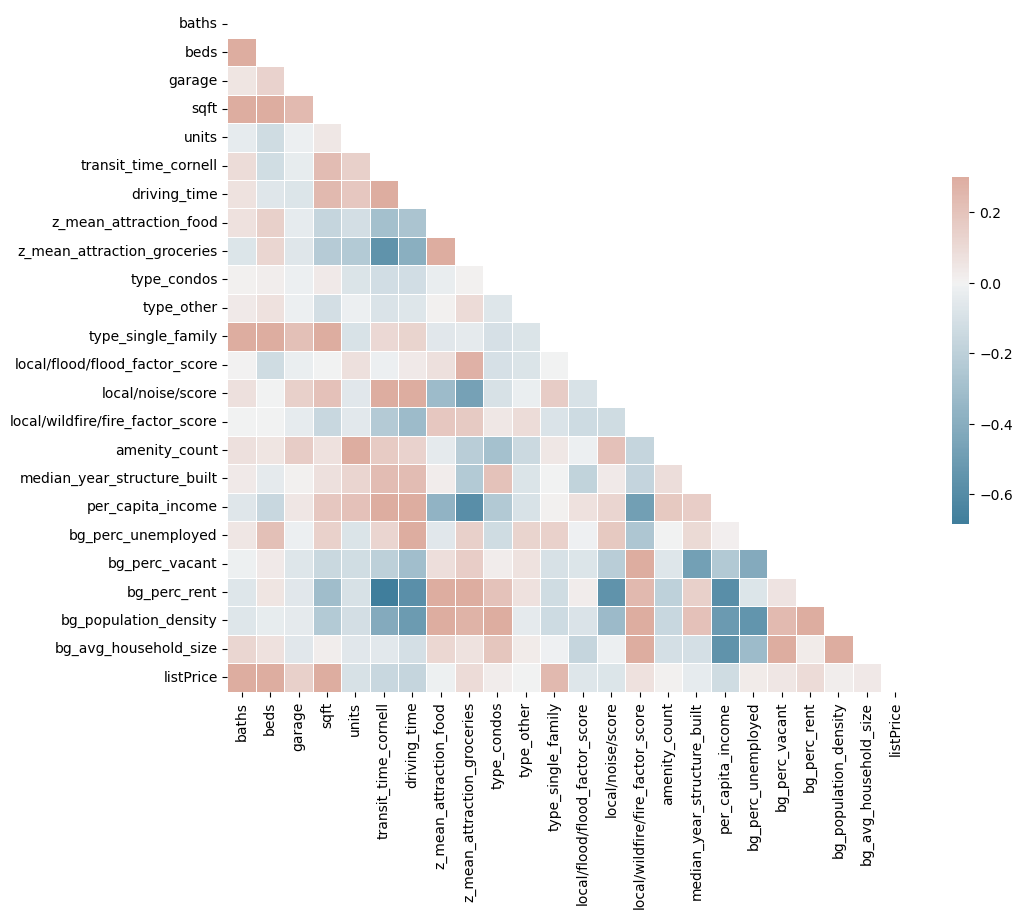

In [36]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [37]:
variable_names = ['baths',
                  'beds', 
                  #'garage', 
                  'sqft', 
                  #'units', 
                  'transit_time_cornell', #'driving_time',
                  'z_mean_attraction_food', 'z_mean_attraction_groceries',
                  #'type_condos', 'type_other', 
                  'type_single_family', 
                  'local/flood/flood_factor_score',
                  'local/noise/score',
                  #'local/wildfire/fire_factor_score', 
                  #'amenity_count'
                 ]

variable_names_acs = variable_names + [#'median_year_structure_built', 
                                       #'per_capita_income', 
                                       'bg_perc_unemployed', 
                                       'bg_perc_vacant',
                                       #'bg_perc_rent', 
                                       #'bg_population_density', 
                                       'bg_avg_household_size']

In [38]:
df_with_acs = df_with_acs.dropna(subset=variable_names_acs)

In [39]:
w_acs_kernel = weights.distance.Kernel.from_dataframe(df_with_acs, k=5, diagonal=False)
w_acs_kernel.transform = 'r'
for i in w_acs_kernel.neighbors:
    w_acs_kernel.neighbors[i] = [j for j in w_acs_kernel.neighbors[i] if i != j]
    w_acs_kernel.weights[i] = [w for j, w in zip(w_acs_kernel.neighbors[i], w_acs_kernel.weights[i]) if i != j]


#w_knn = weights.KNN.from_dataframe(gdf, k=5)

In [40]:
lag_model = spreg.GM_Lag(df_with_acs[["listPrice"]].values, df_with_acs[variable_names_acs].values,
                         w=w_acs_kernel,
                         name_y="rent",name_x=variable_names_acs,
)

In [41]:
print(lag_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :        rent                Number of Observations:         193
Mean dependent var  :   2271.3860                Number of Variables   :          14
S.D. dependent var  :   1340.2401                Degrees of Freedom    :         179
Pseudo R-squared    :      0.4401
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      5005.20454      2936.16258         1.70468         0.08825
               baths       275.18669       158.14004         1.74015         0.08183
 

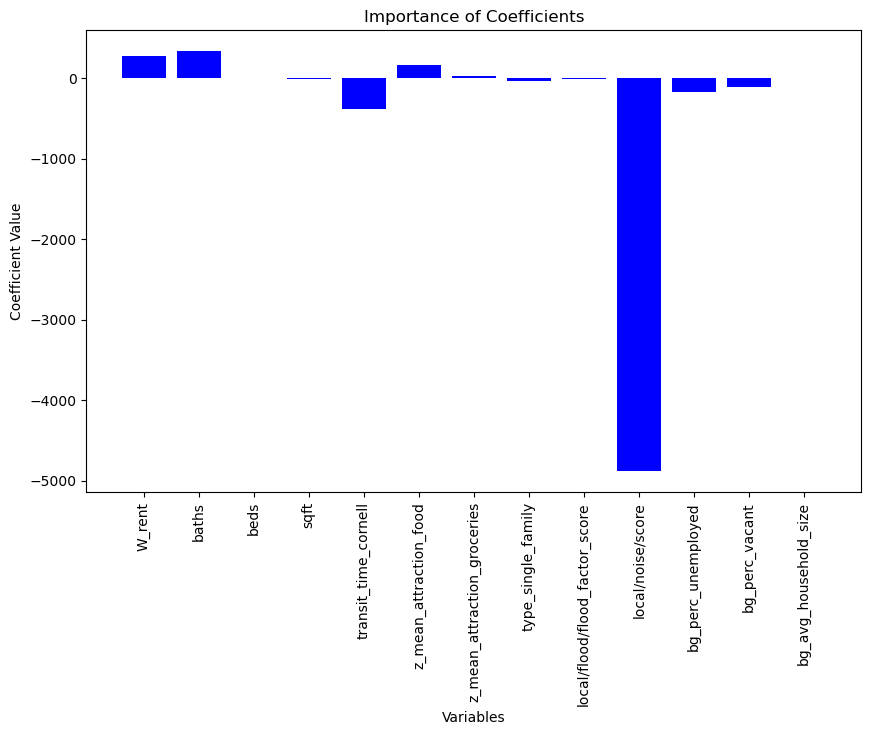

In [42]:
# Get coefficients and variable names
coefficients = lag_model.betas.flatten()  # Flatten in case the betas are in a column vector
variable_names = ["W_rent"] + variable_names_acs  # Assuming variable_names_acs doesn't include the constant

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(variable_names, coefficients[1:], color='b')
plt.xlabel('Variables')
plt.ylabel('Coefficient Value')
plt.title('Importance of Coefficients')
plt.xticks(rotation=90)  # Rotating variable names for better visibility
plt.show()

In [43]:
import spreg

# Fitting the spatial lag model
lag_model = spreg.GM_Lag(df_with_acs[["listPrice"]].values, 
                         df_with_acs[variable_names_acs].values,
                         w=w_acs_kernel,
                         name_y="rent", name_x=variable_names_acs)

# Predicting the values
predicted = lag_model.predy

# Calculating the residuals
residuals = df_with_acs["listPrice"] - predicted.flatten()  # Adjust based on the actual column name of your dependent variable

# Adding predicted and residual columns to the DataFrame
df_with_acs['predicted'] = predicted
df_with_acs['residual'] = residuals
df_with_acs

Unnamed: 0         address/street  baths  beds  coordinates/latitude  \
0             0        809 S Aurora St    2.0   5.0             42.430851   
1             1      419 Triphammer Rd    2.0   6.0             42.460409   
2             2        517 S Aurora St    2.0   6.0             42.435014   
3             3            3 Hudson Pl    1.0   2.0             42.430688   
4             4  600 Warren Rd Apt 4-2    1.5   1.5             42.477345   
..          ...                    ...    ...   ...                   ...   
222         222       519 E Buffalo St    1.0   2.0             42.441285   
223         223       106 Wiedmaier Ct    2.0   3.0             42.413681   
224         224        409 College Ave    1.0   1.5             42.442255   
225         225       103 Wiedmaier Ct    1.5   3.0             42.413895   
226         226          902 Dryden Rd    1.5   2.5             42.453703   

     coordinates/longitude  garage          id  listPrice  is_manual  ...  \
0               -76.496069       0  4208852367     2625.0      False  ...   
1               -76.481516       4  4733433667     5000.0      False  ...   
2               -76.494344       0  4090421202     4350.0      False  ...   
3               -76.493156       0  4199200488     1600.0      False  ...   
4               -76.467567       0  9934501911     1881.0       True  ...   
..                     ...     ...         ...        ...        ...  ...   
222             -76.490701       0  3834217847     1200.0      False  ...   
223             -76.449093       0  3610937531     3244.0       True  ...   
224             -76.484963       0  9523596613     4095.0       True  ...   
225             -76.448010       0  3609558692     1450.0       True  ...   
226             -76.444380       0  3409039337     1975.0       True  ...   

    per_capita_income  bg_total_population bg_population_density  \
0               28690                 2814              951.2947   
1               50877                 1856             2033.8310   
2               28690                 2814              951.2947   
3               28690                 2814              951.2947   
4               50877                 1856             2033.8310   
..                ...                  ...                   ...   
222             35491                  454            10765.7300   
223             47905                 3116              794.9493   
224              6150                 1326            36675.8200   
225             47905                 3116              794.9493   
226             52503                 1135              128.3749   

     bg_avg_household_size  bg_unemployed  bg_perc_vacant  bg_perc_rent  \
0                     1.80            202        0.047619      0.739726   
1                     1.41             40        0.031690      0.527273   
2                     1.80            202        0.047619      0.739726   
3                     1.80            202        0.047619      0.739726   
4                     1.41             40        0.031690      0.527273   
..                     ...            ...             ...           ...   
222                   1.35             23        0.227991      0.760234   
223                   2.44            159        0.048430      0.290292   
224                   2.46              0        0.096045      1.000000   
225                   2.44            159        0.048430      0.290292   
226                   1.68             24        0.192208      0.512862   

     bg_perc_unemployed    predicted     residual  
0              0.071784  3272.753351  -647.753351  
1              0.021552  4645.070198   354.929802  
2              0.071784  4213.751658   136.248342  
3              0.071784  1819.908747  -219.908747  
4              0.021552  1911.562979   -30.562979  
..                  ...          ...          ...  
222            0.050661  1708.955075  -508.955075  
223            0.0510

In [44]:
df_with_acs['value_for_money'] = df_with_acs['residual']

In [45]:
import geopandas as gpd
import folium
from folium.plugins import Search
import branca.colormap as cm

# Assuming df_with_acs is your GeoDataFrame and is already loaded
df_with_acs = df_with_acs.to_crs(epsg=4326)  # Ensure the correct CRS for Folium

# Create a base map
m = folium.Map(location=[df_with_acs.geometry.y.mean(), df_with_acs.geometry.x.mean()], 
               tiles='CartoDB dark_matter', 
               zoom_start=12)

# Color scale for Value for Money
color_scale = cm.linear.PiYG_09.scale(df_with_acs['value_for_money'].min(), df_with_acs['value_for_money'].max())
color_scale.caption = 'Value for Money'

# Create a feature group for CircleMarkers
marker_group = folium.FeatureGroup(name='Markers')

# Add circle markers directly to the feature group
for idx, row in df_with_acs.iterrows():
    color = color_scale(row['value_for_money'])
    radius = 5 + 10 * (row['units'] / max(df_with_acs['units']))  # Scaling the radius based on units

    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=radius,
        popup=folium.Popup(f"Address: {row['address/street']}<br>Rent: {row['listPrice']}<br>Value for Money: {row['value_for_money']}<br>Beds: {row['beds']}<br>Baths: {row['baths']}<br>Square Feet: {row['sqft']}<br>Garage: {row['garage']}<br>Units: {row['units']}", max_width=250),
        color=color,
        weight=3,
        fill=True,
        fill_color=color
    ).add_to(marker_group)

# Add the feature group to the map
marker_group.add_to(m)
color_scale.add_to(m)  # Adding the color scale to the map

# Adding search functionality using a workaround
search = Search(
    layer=marker_group,
    geom_type='Point',
    search_label='properties',  # Ensure this matches with a property in your dataset
    placeholder='Search for an address',
    collapsed=False,
    position='topright'
).add_to(m)

# Display the map
m.save('map.html')
m


In [46]:
df_with_acs_sorted = df_with_acs.sort_values('value_for_money')

top_low_10 = pd.concat([df_with_acs_sorted.head(10), df_with_acs_sorted.tail(10)])
top_low_10

Unnamed: 0                     address/street  baths  beds  \
47           47                      214 Dryden Rd    4.0   7.0   
179         179             416 Hudson St # 416HUD    2.0   6.0   
5             5                    114 Stewart Ave    3.0   7.0   
46           46                       104 Lake Ave    4.0   7.0   
66           66                    205 Williams St    2.0   7.0   
68           68           126 College Ave Unit 201    2.0   6.0   
26           26           126 College Ave Unit 401    2.0   6.0   
23           23            202 Linden Ave Unit 303    1.0   4.0   
71           71              202 Linden Ave Unit 1    1.0   4.0   
42           42                112-114 Schuyler Pl    1.0   3.0   
149         149                     110 Titus # 1A    2.0   2.0   
204         204                      112 Summit St    3.0   3.0   
187         187                    309 S Aurora St    2.0   3.5   
41           41             218 Delaware Ave Apt 4    2.0   5.0   
224         224                    409 College Ave    1.0   1.5   
188         188                    522 Stewart Ave    2.5   5.0   
31           31  708 E Seneca-3 708 Sen St E # 1-2    3.0  10.0   
176         176                     306 Bryant Ave    2.0   5.0   
194         194                    129 College Ave    3.0   8.0   
69           69                     111 Harvard Pl    3.0   7.0   

     coordinates/latitude  coordinates/longitude  garage          id  \
47              42.441896             -76.484229       0  9725975963   
179             42.435165             -76.492434       0  4079390483   
5               42.440100             -76.489955       0  3898203471   
46              42.444748             -76.499762       0  9843308796   
66              42.442171             -76.488493       0  3844018790   
68              42.438778             -76.485321       0  9320578554   
26              42.438778             -76.485321       0  9708488612   
23              42.439472             -76.484375       0  9777901913   
71              42.439472             -76.484375       0  9697687795   
42              42.439892             -76.492302       0  9356349145   
149             42.435417             -76.499695       0  9597377586   
204             42.442169             -76.483081       0  4465034930   
187             42.437196             -76.494479       0  3992635369   
41              42.440521             -76.483574       0  9004188671   
224             42.442255             -76.484963       0  9523596613   
188             42.444431             -76.489685       0  9089162976   
31              42.440922             -76.489113       0  9648829532   
176             42.440925             -76.483697       0  3857918987   
194             42.439202             -76.484891       0  3875955703   
69              42.440337             -76.481730       0  3886613762   

     listPrice  is_manual  ... bg_total_population  bg_population_density  \
47       850.0      False  ...                1326             36675.8200   
179      725.0       True  ...                2814               951.2947   
5        850.0      False  ...                1281             18926.7000   
46       825.0      False  ...                1164              3351.6800   
66       995.0      False  ...                1326             36675.8200   
68      1417.0      False  ...                1281             18926.7000   
26      1417.0      False  ...                1281             18926.7000   
23       900.0      False  ...                1684             71402.3300   
71      1285.0      False  ...                1684             71402.3300   
42       775.0      False  ...                1221             13065.9400   
149     3500.0      False  ...                2062              9379.9100   
204     5100.5       True  ...                1326             36675.8200   
187     4550.0      False  ...                2814               951.2947   
41    

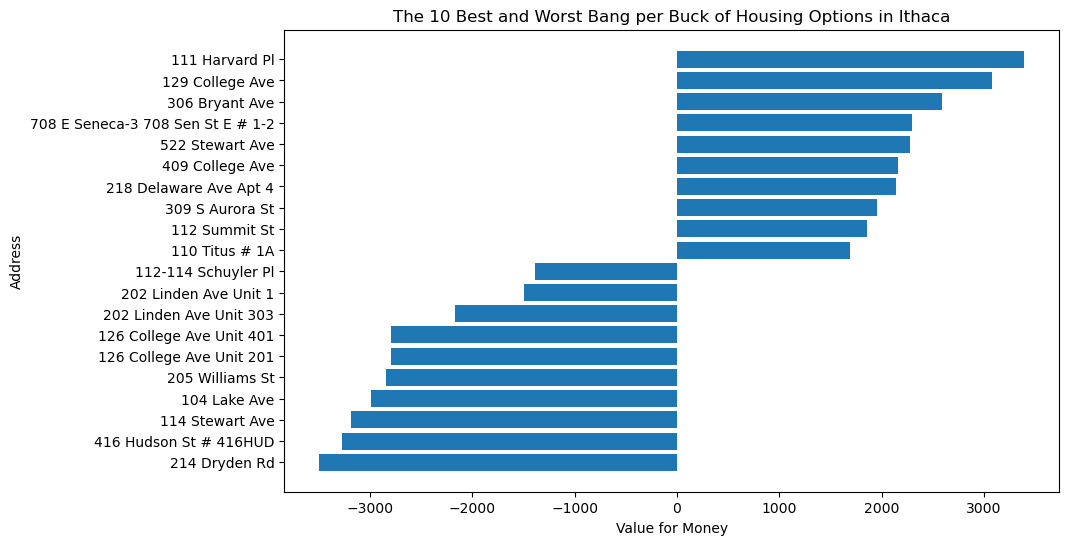

In [47]:
plt.figure(figsize=(10, 6))
plt.barh(top_low_10['address/street'], top_low_10['value_for_money'])
plt.xlabel('Value for Money')
plt.ylabel('Address')
plt.title('The 10 Best and Worst Bang per Buck of Housing Options in Ithaca')
plt.show()

In [48]:
variable_names = ['baths',
                  'beds', 
                  'garage', 
                  'sqft', 
                  'units', 
                  'transit_time_cornell', 'driving_time',
                  'z_mean_attraction_food', 'z_mean_attraction_groceries',
                  'type_condos', 'type_other', 
                  'type_single_family', 
                  'local/flood/flood_factor_score',
                  'local/noise/score',
                  'local/wildfire/fire_factor_score', 
                  'amenity_count'
                 ]

variable_names_acs = variable_names + ['median_year_structure_built', 
                                       'per_capita_income', 
                                       'bg_perc_unemployed', 
                                       'bg_perc_vacant',
                                       'bg_perc_rent', 
                                       'bg_population_density', 
                                       'bg_avg_household_size']


# List of variables to exclude from standardization
exclude_standardization = ['baths', 'beds', 'z_mean_attraction_food', 'z_mean_attraction_groceries',
                           'type_condos', 'type_other', 'type_single_family']

# Variables to standardize
variables_to_standardize = [var for var in variable_names_acs if var not in exclude_standardization]

# Calculate the mean and standard deviation for the variables to be standardized
means = df_with_acs[variables_to_standardize].mean()
stds = df_with_acs[variables_to_standardize].std()

# Standardize the selected variables
df_with_acs_z = df_with_acs.copy()
df_with_acs_z[variables_to_standardize] = (df_with_acs[variables_to_standardize] - means) / stds

df_with_acs_z

Unnamed: 0         address/street  baths  beds  coordinates/latitude  \
0             0        809 S Aurora St    2.0   5.0             42.430851   
1             1      419 Triphammer Rd    2.0   6.0             42.460409   
2             2        517 S Aurora St    2.0   6.0             42.435014   
3             3            3 Hudson Pl    1.0   2.0             42.430688   
4             4  600 Warren Rd Apt 4-2    1.5   1.5             42.477345   
..          ...                    ...    ...   ...                   ...   
222         222       519 E Buffalo St    1.0   2.0             42.441285   
223         223       106 Wiedmaier Ct    2.0   3.0             42.413681   
224         224        409 College Ave    1.0   1.5             42.442255   
225         225       103 Wiedmaier Ct    1.5   3.0             42.413895   
226         226          902 Dryden Rd    1.5   2.5             42.453703   

     coordinates/longitude     garage          id  listPrice  is_manual  ...  \
0               -76.496069  -0.071982  4208852367     2625.0      False  ...   
1               -76.481516  13.820462  4733433667     5000.0      False  ...   
2               -76.494344  -0.071982  4090421202     4350.0      False  ...   
3               -76.493156  -0.071982  4199200488     1600.0      False  ...   
4               -76.467567  -0.071982  9934501911     1881.0       True  ...   
..                     ...        ...         ...        ...        ...  ...   
222             -76.490701  -0.071982  3834217847     1200.0      False  ...   
223             -76.449093  -0.071982  3610937531     3244.0       True  ...   
224             -76.484963  -0.071982  9523596613     4095.0       True  ...   
225             -76.448010  -0.071982  3609558692     1450.0       True  ...   
226             -76.444380  -0.071982  3409039337     1975.0       True  ...   

    bg_total_population  bg_population_density bg_avg_household_size  \
0                  2814              -0.692268             -0.161063   
1                  1856              -0.621947             -0.890061   
2                  2814              -0.692268             -0.161063   
3                  2814              -0.692268             -0.161063   
4                  1856              -0.621947             -0.890061   
..                  ...                    ...                   ...   
222                 454              -0.054726             -1.002214   
223                3116              -0.702424              1.035240   
224                1326               1.628385              1.072625   
225                3116              -0.702424              1.035240   
226                1135              -0.745725             -0.385370   

     bg_unemployed  bg_perc_vacant  bg_perc_rent  bg_perc_unemployed  \
0              202       -0.780151      0.068029            1.512771   
1               40       -1.003232     -0.965223           -0.279292   
2              202       -0.780151      0.068029            1.512771   
3              202       -0.780151      0.068029            1.512771   
4               40       -1.003232     -0.965223           -0.279292   
..             ...             ...           ...                 ...   
222             23        1.745921      0.167768            0.759191   
223            159       -0.768787     -2.117761            0.772254   
224              0       -0.101953      1.333853           -1.048163   
225            159       -0.768787     -2.117761            0.772254   
226             24        1.244785     -1.035310           -0.293789   

       predicted     residual  value_for_money  
0    3272.753351  -647.753351      -647.753351  
1    4645.070198   354.929802       354.929802  
2    4213.751658   136.248342       136.248342  
3    1819.908747  -219.908747      -219.908747  
4    1911.562979   -30.562979       -30.562979  
..           ...          ...              ...  
222  1708.955075  -508.955075      -508.955075

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :        rent                Number of Observations:         193
Mean dependent var  :   2271.3860                Number of Variables   :          20
S.D. dependent var  :   1340.2401                Degrees of Freedom    :         173
Pseudo R-squared    :      0.4560
Spatial Pseudo R-squared:  0.4571

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       553.59549      2700.01000         0.20503         0.83755
               baths       171.28491       161.07067         1.06341         0.28759
                beds       361.68514      

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (20,) and arg 3 with shape (18,).

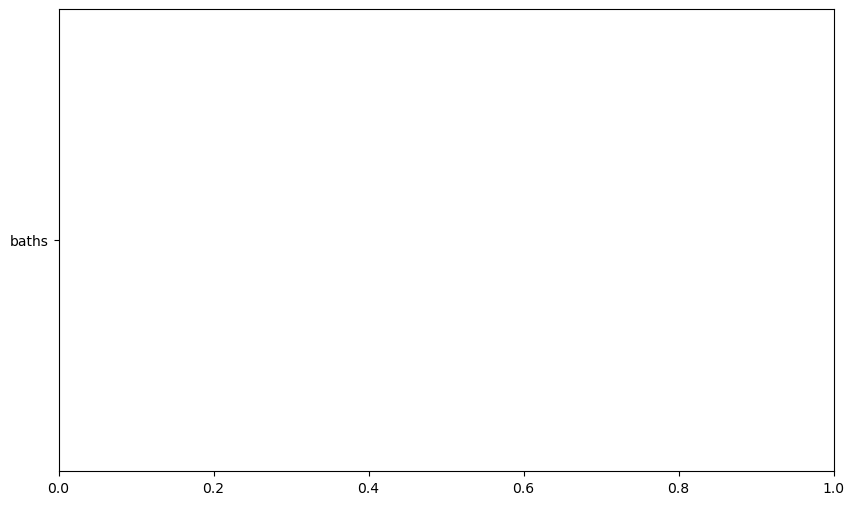

In [65]:
lag_model = spreg.GM_Lag(df_with_acs_z[["listPrice"]].values, df_with_acs_z[variable_names_acs].values,
                         w=w_acs_kernel,
                         name_y="rent",name_x=variable_names_acs,
)

print(lag_model.summary)

# Get coefficients and variable names
coefficients = lag_model.betas.flatten() # Flatten in case the betas are in a column vector
variable_names = ["W_rent"] + variable_names_acs  # Assuming variable_names_acs doesn't include the constant

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(lag_model.name_x[1:], coefficients, color='b')
plt.xlabel('Variables')
plt.ylabel('Coefficient Value')
plt.title('Importance of Coefficients')
plt.xticks(rotation=90)  # Rotating variable names for better visibility
plt.show()

In [66]:
lag_model.name_x[1:]

['baths',
 'beds',
 'sqft',
 'transit_time_cornell',
 'driving_time',
 'z_mean_attraction_food',
 'z_mean_attraction_groceries',
 'type_single_family',
 'local/flood/flood_factor_score',
 'local/noise/score',
 'amenity_count',
 'median_year_structure_built',
 'per_capita_income',
 'bg_perc_unemployed',
 'bg_perc_vacant',
 'bg_perc_rent',
 'bg_population_density',
 'bg_avg_household_size']

In [67]:
lag_model.betas

array([[ 5.53595491e+02],
       [ 1.71284909e+02],
       [ 3.61685136e+02],
       [ 3.37618122e+02],
       [ 4.45103383e+02],
       [-5.59312993e+02],
       [-4.33821174e+02],
       [ 1.68793669e+02],
       [ 5.06024835e+01],
       [-6.60251278e+01],
       [-2.18201599e+02],
       [ 1.15460609e+00],
       [ 2.98746375e+01],
       [-1.76164918e+02],
       [-1.66653204e+02],
       [-5.68654680e+01],
       [ 8.27140617e+01],
       [-1.92977449e+02],
       [-9.93365318e+01],
       [ 1.80949637e-01]])

In [50]:
# Prepare the data
X = df_with_acs[variable_names_acs]  # Features
y = df_with_acs['listPrice']  # Target variable, assuming 'listPrice' is your target variable name and not 'rent' as implied in your spatial lag model parameters

# Add a constant to the model (best practice for OLS)
X = sm.add_constant(X)

# Create the OLS model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              listPrice   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     6.316
Date:                Sat, 04 May 2024   Prob (F-statistic):           1.72e-13
Time:                        16:41:56   Log-Likelihood:                -1603.2
No. Observations:                 193   AIC:                             3254.
Df Residuals:                     169   BIC:                             3333.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [51]:
# Normalize/Standardize features
scaler_x = StandardScaler()
X = scaler_x.fit_transform(df_with_acs[variable_names_acs].values)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(df_with_acs[["listPrice"]].values)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"R^2: {r2:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

Epoch 1/50
4/4 [==============================] - 1s 47ms/step - loss: 3.3862 - val_loss: 1.0611
Epoch 2/50
4/4 [==============================] - 0s 8ms/step - loss: 3.1917 - val_loss: 1.0154
Epoch 3/50
4/4 [==============================] - 0s 8ms/step - loss: 2.8693 - val_loss: 0.9788
Epoch 4/50
4/4 [==============================] - 0s 8ms/step - loss: 2.3118 - val_loss: 0.9517
Epoch 5/50
4/4 [==============================] - 0s 8ms/step - loss: 2.0930 - val_loss: 0.9280
Epoch 6/50
4/4 [==============================] - 0s 8ms/step - loss: 1.8196 - val_loss: 0.9079
Epoch 7/50
4/4 [==============================] - 0s 8ms/step - loss: 2.0750 - val_loss: 0.8846
Epoch 8/50
4/4 [==============================] - 0s 8ms/step - loss: 1.7264 - val_loss: 0.8727
Epoch 9/50
4/4 [==============================] - 0s 8ms/step - loss: 1.3616 - val_loss: 0.8618
Epoch 10/50
4/4 [==============================] - 0s 8ms/step - loss: 1.6406 - val_loss: 0.8596
Epoch 11/50
4/4 [=====================

In [52]:
variable_names = ['baths',
                  'beds', 
                  #'garage', 
                  'sqft', 
                  #'units', 
                  'transit_time_cornell', 'driving_time',
                  'z_mean_attraction_food', 'z_mean_attraction_groceries',
                  #'type_condos', 'type_other', 
                  'type_single_family', 
                  'local/flood/flood_factor_score',
                  'local/noise/score',
                  #'local/wildfire/fire_factor_score', 
                  'amenity_count'
                 ]

variable_names_acs = variable_names + ['median_year_structure_built', 
                                       'per_capita_income', 
                                       'bg_perc_unemployed', 
                                       'bg_perc_vacant',
                                       'bg_perc_rent', 
                                       'bg_population_density', 
                                       'bg_avg_household_size']

In [53]:
# Prepare the data
X = df_with_acs[variable_names_acs].values  # Features
y = df_with_acs['listPrice'].values  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=90, random_state=42)

# Train the model
random_forest_model.fit(X_train, y_train)

# Predict on the test set
y_pred = random_forest_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"R^2 Score: {r2:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

R^2 Score: 0.15
MSE: 1447275.23
RMSE: 1203.03
